<center><h1> Sentiment Analysis: tweet classifier  </h1> </center>


<br>
<p> Sentiment analysis is part of Natural Language Processing (NLP) and aims to determine the underlying emotional tone of a string of words to classify them as positive, negative or neutral. This is one way in which organizations can determine and categorize opinions about their products, services or brand. Sentiment analysis involves the use of data mining, machine learning (ML) models, deep learning (DL) and computational linguistics for text extraction and analysis.</p>

<p>The objective of this project is to implement ML models for the classification of tweets as racist or non-racist and to evaluate which ML model has the best performance.</p>

<h3>Description </h3>

<p>The objective of this project is to implement ML models for the classification of tweets as racist or non-racist. In short, a tweet contains hate speech if it has a racist or sexist sentiment associated with it. Therefore, the task is to classify racist or sexist tweets from other tweets. Thus, the label "1" indicates that the tweet is racist/sexist and the label "0" indicates that the tweet is not racist/sexist.</p>

<h3>About the dataset</h3>

The full texts of tweets are provided with their tags for training data. The username of the mentioned users is replaced by @user.

The dataset has been provided by Analytics Vidhya and you can explore it <a HREF = "https://www.kaggle.com/code/helayahyaoui/nlp-twitter-sentiment-analysis/data"> HERE.</a>

<h3> Objetives </h3>
<ul>
    <li> Pre-processing data. </li>
    <li> Construction of three ML models to evaluate which one works best. </li>
</ul>

<h2> Outline </h2>

<ol>
    <li> Data exploration. </li>
    <li> Pre-processing data</li>
    <li> Exploration data analysis (EDA).</li>
    <li> Application of TF-IDF </li>
    <li> Spliting training and test data. </li>
    <li> Application and evaluation of machine learning models. </li>
    <li> Conclusions. </li>
</ol>

<center> <h3> 1.Data Exploration </h3> </center>

In [1]:
##  Import libraries

import pandas as pd
import numpy as np

import re
import contractions
from collections import Counter

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
porter = PorterStemmer()
lem = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 


import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
## Upload dataset
# ==========================================================

data = pd.read_csv('train.csv')

In [3]:
print('Training set:'% data.columns, data.shape)

Training set: (31962, 3)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


> <b>Inference </b>: the dataset contains 3 features and 31,962 samples. 

In [6]:
## Conteo de valores nulos
# ================================================

data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

> <b> Inference</b>: There aren't null values. 

In [4]:
##  Data visualization
# ==========================================================

data.sample(10)

,id,label,tweet
19541,19542,1,if you think about it you are the one ð¤£ð...
30944,30945,0,so to have been able to go to a #braves #bas...
24760,24761,0,"#fathersday #selfie ðâ¤ i love my daddy,..."
10334,10335,0,@user for it was not into my ear you whispere...
412,413,0,have a happy sunday everyone! i think today is...
3832,3833,0,finally i got home 5 hours ago why is it that ...
16116,16117,0,@user why is your mother friending your ex on...
22730,22731,0,"i really, really love making games! and it's f..."
23250,23251,0,@user @user yep!! back to #sameolestory some b...
1956,1957,0,sunday vibes ð¡ || #sunday #vibes #game #hol...


C:\Users\carlo\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Non-racist'), Text(1, 0, 'Racist')]

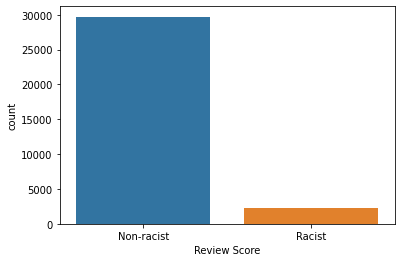

In [5]:
## Count labels
# ==========================================================

class_names = ['Non-racist', 'Racist']
ax = sns.countplot(data.label)
plt.xlabel('Review Score')
ax.set_xticklabels(class_names)

> <b>Inference</b>: the labels of the data set show an imbalance.

<center> <h3> 2. Pre-processing data </h3> </center>

In [6]:
def data_clean(data):
    global simbolos, stop_words
    
    ## Regular Expression 
    a = re.sub(r'(@[A-Za-z0-9]+)|(\d+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?',' ', 
               contractions.fix(data.replace('\n',' '))).replace(' s ',' ').lower() 
    
    ## Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatization = []
    for k in a.split():
        lemmatization.append(lemmatizer.lemmatize(k))
    a = ' '.join(lemmatization)
    
    ## Word tokenize
    text=[]
    for k in word_tokenize(a):
        if k not in stop_words:
            text.append(k)
    a = ' '.join(text)
    
    return a

In [7]:
# Apply the data cleaning function
# ==========================================================

data['tweet'] = data['tweet'].apply(data_clean)

In [12]:
## Checking changes
# ===========================================================

df_clean = data
df_clean.sample(15)

,id,label,tweet
19617,19618,0,omg guy sister wedding week
26578,26579,0,oh asandande shezi bihday
3998,3999,0,incompetence highest level leader joke continu...
28730,28731,0,yeah lion good remember look like hair lol
16646,16647,0,back day anything doggy love dog print model p...
18525,18526,0,another day happier ever newday fresh
22400,22401,0,lovely day family father day snuggle babe rest...
15558,15559,0,soon owl babyanimals
1323,1324,0,alfie met billy annaswelshzoo goat friend love
5139,5140,0,school place find educationfest


> <b>Inference</b>: the data cleaning was successful. 

In [14]:
## Check for irrelevant words
# ==========================================================

df_clean[df_clean['tweet'].apply(lambda x:len(x))<=2]

,id,label,tweet
506,507,0,
1961,1962,0,
3351,3352,0,
3982,3983,0,
4411,4412,0,
4799,4800,0,
5028,5029,0,
5235,5236,0,
5309,5310,0,
5892,5893,0,xx


> <b>Inference:</b> there are words that do not provide relevant information because they are not significant in themselves. They are eliminated.

In [15]:
# Removing irrelavant words
# ==========================================================

df_clean = df_clean[df_clean['tweet'].apply(lambda x : len(x)>2)]

<center> <h3> 3. Exploration Data Analysis (EDA) </h3> </center>

In [16]:
## Frequency words

Total_words = Counter(' '.join(df_clean['tweet'].to_list()).split())
Frequency_words = pd.DataFrame([Total_words]).transpose().reset_index().rename(columns = {'index': 'Words', 0:'Frequency' })
Frequency_words = Frequency_words.sort_values('Frequency',ascending=False).reset_index(drop='index').reset_index().rename(columns={'index':'Rank'})
Frequency_words['Rank'] = Frequency_words['Rank'].apply(lambda x : x+1)
Frequency_words.head(20)

,Rank,Words,Frequency
0,1,day,2923
1,2,love,2898
2,3,amp,1777
3,4,happy,1707
4,5,life,1268
5,6,time,1262
6,7,like,1222
7,8,today,1106
8,9,new,1003
9,10,get,1003


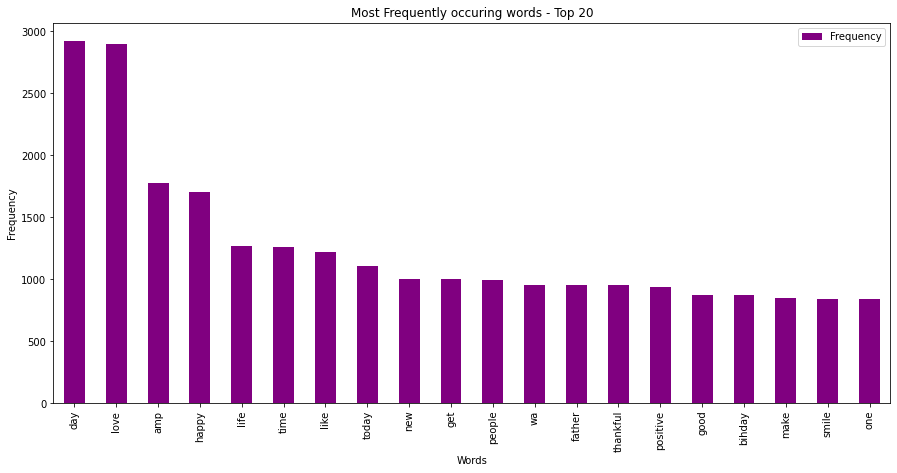

In [17]:
## Chart of the 20 most popular words
# =====================================================================================

Top_words = Frequency_words[['Words','Frequency']].head(20)
Top_words.plot(x="Words", y="Frequency", kind='bar',  figsize=(15,7), color = 'purple')
plt.title("Most Frequently occuring words - Top 20")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

> <b> Inference</b>: the most frequency words: <i>day</i>, <i>love</i>, <i>amp</i>, <i>happy</i>, <i>day</i>. 

Text(0.5, 1.0, 'WordCloud - All Words')

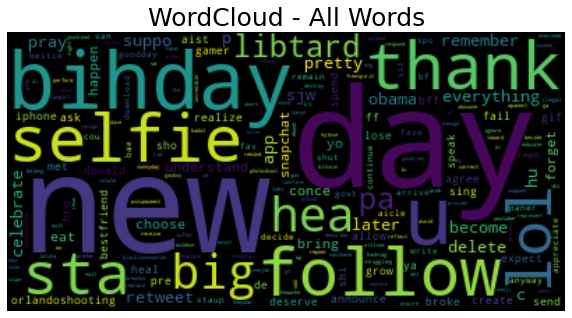

In [18]:
#  WordCloud chart 
# ===================================================================

WC_all_words = " ".join(Frequency_words['Words'])
wordcloud = WordCloud().generate(WC_all_words )

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - All Words", fontsize= 25)

In [19]:
# The most popular racists words: Top 20
# ====================================================================================================================================================

Racist_words = df_clean[df_clean['label'] == 1]
Racist_words = Counter(' '.join(Racist_words['tweet'].to_list()).split())
Freq_racist_words = pd.DataFrame([Racist_words]).transpose().reset_index().rename(columns= {'index': 'Words', 0: 'Frequency'})
Freq_racist_words = Freq_racist_words.sort_values('Frequency',ascending=False).reset_index(drop='index').reset_index().rename(columns={'index':'Rank'})
Freq_racist_words['Rank'] = Freq_racist_words['Rank'].apply(lambda x : x+1)
Freq_racist_words.head(20)

,Rank,Words,Frequency
0,1,amp,300
1,2,trump,217
2,3,white,156
3,4,libtard,149
4,5,black,149
5,6,like,140
6,7,woman,122
7,8,racist,114
8,9,people,106
9,10,politics,97


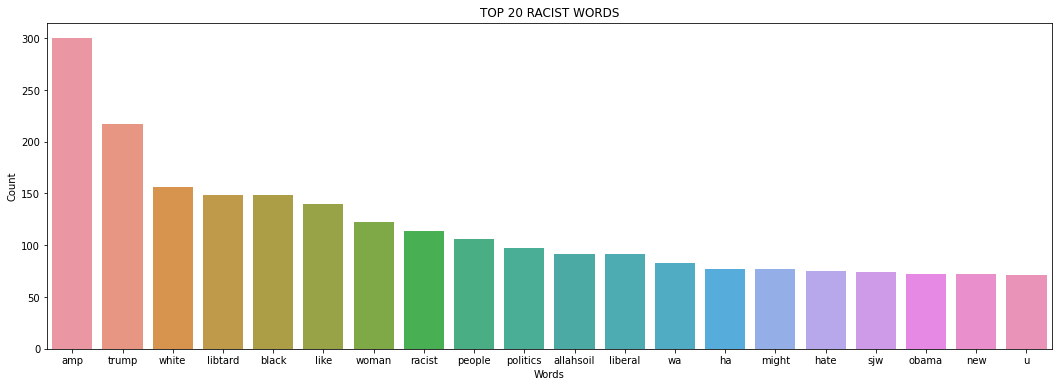

In [20]:
# graph top 20 racist words
# =====================================================================

Top_racist_words = Freq_racist_words[['Words', 'Frequency']].head(20)
plt.figure(figsize=(18,6))
ax = sns.barplot(data = Top_racist_words, x = 'Words', y = 'Frequency')
ax.set(ylabel = 'Count')
plt.title("TOP 20 RACIST WORDS")
plt.show()

> <b> Inference</b> The most popular racist words:. <i>amp</i>, <i>trump</i>, <i>white</i> y <i>black</i>.

Text(0.5, 1.0, 'WordCloud - Racist Words')

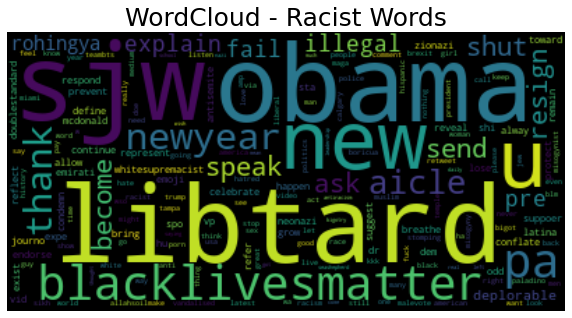

In [21]:
# WordCloud racists words
# ==========================================================

WC_racist_words = " ".join(Freq_racist_words['Words'])
wordcloud = WordCloud().generate(WC_racist_words)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Racist Words", fontsize= 25)

In [22]:
# Top 20 word non-racists
# ========================================================================================================================================================

Unracist_words = df_clean[df_clean['label'] == 0]
Unracist_words = Counter(' '.join(df_clean['tweet'].to_list()).split())
Freq_unracist_words= pd.DataFrame([Unracist_words]).transpose().reset_index().rename(columns= {'index': 'Words', 0: 'Frequency'})
Freq_unracist_words = Freq_unracist_words.sort_values('Frequency',ascending=False).reset_index(drop='index').reset_index().rename(columns={'index':'Rank'})
Freq_unracist_words['Rank'] = Freq_unracist_words['Rank'].apply(lambda x : x+1)
Freq_unracist_words.head(20)

,Rank,Words,Frequency
0,1,day,2923
1,2,love,2898
2,3,amp,1777
3,4,happy,1707
4,5,life,1268
5,6,time,1262
6,7,like,1222
7,8,today,1106
8,9,new,1003
9,10,get,1003


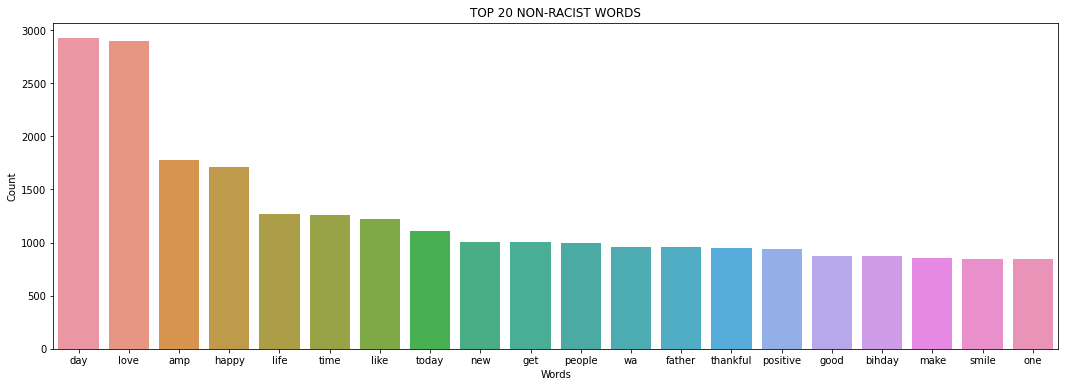

In [23]:
# graph top 20 non-racist words
# ==========================================================================

Top_non_racist_words = Freq_unracist_words[['Words', 'Frequency']].head(20)

plt.figure(figsize=(18,6))
ax = sns.barplot(data = Top_non_racist_words , x = 'Words', y = 'Frequency')
ax.set(ylabel = 'Count')
plt.title("TOP 20 NON-RACIST WORDS")
plt.show()

> <b>Inference</b>: the most popular words: <i>day</i>, <i>love</i>, <i>amp</i> and <i>happy</i>.

Text(0.5, 1.0, 'WordCloud - Non-racist Words')

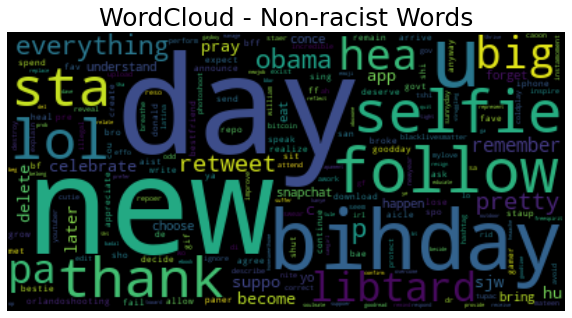

In [24]:
# WordCloud non-racist ords
# ==========================================================

WC_unracist_words = " ".join(Freq_unracist_words['Words'])
wordcloud = WordCloud().generate(WC_unracist_words)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Non-racist Words", fontsize= 25)

<center> <h3> 4. Application of TF-IDF </h3> </center>

In [25]:
targets = df_clean['label']
corpus = df_clean['tweet'].values

In [26]:
## TF-IDF
# ======================================================

vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus = vectorizer.transform(corpus) 

<center> <h3> 5. Spliting training and test data. </h3> </center>

In [27]:
## Split training and test data
# ========================================================

X_train, X_test, y_train, y_test = train_test_split(
                                   corpus, targets,
                                   test_size=0.2,  
                                   stratify=targets, 
                                   random_state = 2) 

In [28]:
Counter(targets)

Counter({0: 29677, 1: 2238})

<center> <h3> 6. Application and evaluation of machine learning models </h3> </center>

Machine Learnig models:

<ul>
    <li> SVM</li>
    <li> Logistic Regression </li>
    <li> Random Forest </li>
</ul>


<p> <b>NOTE</b>: First, ML models will be implemented with unbalanced label data, then balancing techniques will be applied to finally evaluate which model performed best. </p>

<h4> 6.1 SVM Model </h4>

In [29]:
## SVM lineal Model
# ============================================================
svm_model = SVC(C = 10, kernel = 'linear', random_state=123)
svm_model.fit(X_train, y_train)

# Predicciones sobre los datos de test
# ============================================================
predictions = svm_model.predict(X_test)


# Model F1 score
# ============================================================

f1_sc_svm_1 = f1_score(
        y_true = y_test, 
        y_pred = predictions, 
        average="micro"
        )

print(f"F1 score for test data: {100*f1_sc_svm_1:.2f}%")

F1 score for test data: 96.10%


In [30]:
## Confusion Matrix: SVM 
# ==============================================================

confusion_matrix = pd.crosstab(
    y_test.ravel(),
    predictions,
    rownames=['Real'],
    colnames=['Prediction']
)
confusion_matrix

Prediction,0,1
Real,,
0,5859,76
1,173,275


Model 1 AUC score : 87.74% 


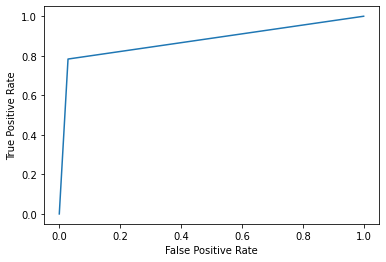

In [31]:
## ROC CURVE : SVM
# ==============================================================

def plot_roc_curve(predict, y_test):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(predict, y_test)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(predictions, y_test)
print(f'SVM Model AUC score : {100*roc_auc_score(predictions, y_test):.2f}% ')

<h4> 6.2 Logistic Regression Model. </h4>

In [32]:
# Logistic Regression model 
# ========================================================================

Logi_Reg = LogisticRegression(penalty = 'l2', random_state = 123)
Logi_Reg.fit(X_train, y_train)

# Test predicctions
# ========================================================================

predictions = Logi_Reg.predict(X_test)

# F1 score
# ========================================================================

f1_sc_lr_1 = f1_score(
        y_true = y_test, 
        y_pred = predictions, 
        average="micro"
        )

print(f"F1 score for test data: {100*f1_sc_lr_1:.2f}%")

F1 score for test data: 94.85%


In [33]:
# Confusion Matrix: Logistic Regression 
# ========================================================================

confusion_matrix = pd.crosstab(
    y_test.ravel(),
    predictions,
    rownames=['Real'],
    colnames=['Prediction']
)
confusion_matrix

Prediction,0,1
Real,,
0,5930,5
1,324,124


Model 1 AUC score : 95.47% 


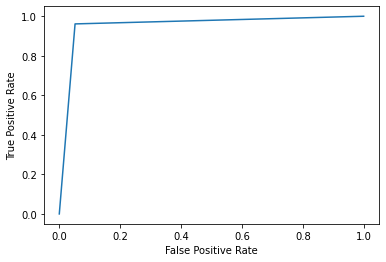

In [34]:
## ROC CURVE : lOGISTIC REGRESSION
# ========================================================================

def plot_roc_curve(predict, y_test):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(predict, y_test)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(predictions, y_test)
print(f'Logistic Regression Model AUC score : {100*roc_auc_score(predictions, y_test):.2f}% ')

<h4> 6.3 Random Forest Model </h4>

In [35]:
## Random Forest 
# ============================================================
clf = RandomForestClassifier(n_estimators=100, random_state=123)
clf.fit(X_train, y_train) 

# Test predicctions
# ============================================================
predictions = clf.predict(X_test)

# F1 score
# ============================================================

f1_sc_rf_1 = f1_score(
        y_true = y_test, 
        y_pred = predictions, 
        average="micro"
        )

print(f"F1 score for test data: {100*f1_sc_rf_1:.2f}%")

F1 score for test data: 96.40%


In [36]:
# Matrix confusion Random Forest 
# ========================================================================

confusion_matrix = pd.crosstab(
    y_test.ravel(),
    predictions,
    rownames=['Real'],
    colnames=['Prediction']
)
confusion_matrix

Prediction,0,1
Real,,
0,5921,14
1,216,232


Model 1 AUC score : 95.39% 


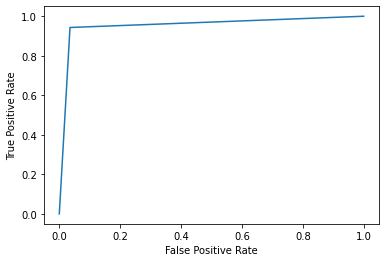

In [37]:
## ROC CURVE : RANDOM FOREST
# ========================================================================

def plot_roc_curve(predict, y_test):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(predict, y_test)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(predictions, y_test)
print(f'Random Forest Model AUC score : {100*roc_auc_score(predictions, y_test):.2f}% ')

In [45]:
print(f">F1 Score SVM: {100*f1_sc_svm_1:.2f}%. \n>F1 Score Logistic Reggression: {100*f1_sc_lr_1:.2f}%. \n>F1 Score Random Forest:{100*f1_sc_rf_1:.2f}%.")

>F1 Score SVM: 96.10%. 
>F1 Score Logistic Reggression: 94.85%. 
>F1 Score Random Forest:96.40%.


> <b>Inference:</b> The Logistic Regression model obtained the best score. 

<h3> Undersampling & Oversampling </h3>

<h4> Undersample </h4>

Random undersamplig deletes examples from the majority class. 

In [46]:
# undersample balance
# ====================================================

undersample = RandomUnderSampler(sampling_strategy='majority')
data, targ_under = undersample.fit_resample(corpus, targets)

In [47]:
# Count targets  
# ====================================================

Counter(targ_under)

Counter({0: 2238, 1: 2238})

C:\Users\carlo\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Non-racist'), Text(1, 0, 'Racist')]

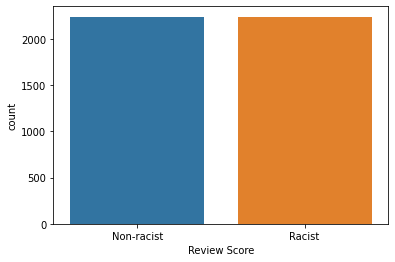

In [48]:
# Gráfico de las etiquetas balanceadas 
# ====================================================

class_names = ['Non-racist', 'Racist']
ax = sns.countplot(targ_under)
plt.xlabel('Review Score')
ax.set_xticklabels(class_names)

In [49]:
# Split training and test data
# ===========================================================================

X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    targ_under, 
                                                    test_size=0.2, 
                                                    stratify=targ_under, 
                                                    random_state=2)

<h4> 6.4 SVM Model </h4>

In [51]:
# SVM lineal Model
# ==============================================================

svm_model = SVC(C = 200, kernel = 'linear', random_state=123)
svm_model.fit(X_train, y_train)

# Test predicctions
# ==============================================================
predictions = svm_model.predict(X_test)

# Accuracy score
# ==============================================================
acc_smv_2 = accuracy_score(
            y_true    = y_test,
            y_pred    = predictions,
            normalize = True
           )

print(f"Accuracy score for test data: {100*acc_smv_2 :.2f}%")

Accuracy score for test data: 87.05%


In [52]:
# Matriz de confusión: SVM 
# ==============================================

confusion_matrix = pd.crosstab(
    y_test.ravel(),
    predictions,
    rownames=['Real'],
    colnames=['Prediction']
)
confusion_matrix

Prediction,0,1
Real,,
0,391,57
1,59,389


Model 1 AUC score : 87.05% 


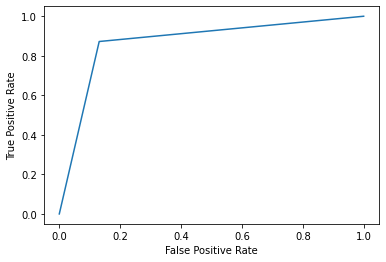

In [53]:
## ROC CURVE : SVM
# ==============================================

def plot_roc_curve(predict, y_test):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(predict, y_test)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(predictions, y_test)
print(f'SVM Model AUC score : {100*roc_auc_score(predictions, y_test):.2f}% ')

<b> 6.5 Logistic Regression Model </b>

In [58]:
# Logistic Regression model 
# ========================================================================

Logi_Reg = LogisticRegression(penalty = 'l2', random_state = 123)
Logi_Reg.fit(X_train, y_train)

# Test predicctions
# ========================================================================

predictions = Logi_Reg.predict(X_test)

# Accuracy Score
# ========================================================================

acc_lr_2 = accuracy_score(
            y_true    = y_test,
            y_pred    = predictions,
            normalize = True
           )

print(f"F1 score for test data: {100*acc_lr_2:.2f}%")

F1 score for test data: 88.28%


In [59]:
# Confusion Matrix: Logistic Regression 
# ========================================================================

confusion_matrix = pd.crosstab(
    y_test.ravel(),
    predictions,
    rownames=['Real'],
    colnames=['Prediction']
)
confusion_matrix

Prediction,0,1
Real,,
0,413,35
1,70,378


Logistic Regression AUC score : 88.52% 


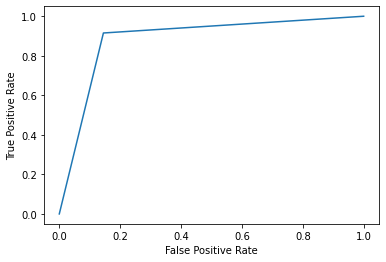

In [60]:
## ROC CURVE : lOGISTIC REGRESSION
# ========================================================================

def plot_roc_curve(predict, y_test):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(predict, y_test)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(predictions, y_test)
print(f'Logistic Regression AUC score : {100*roc_auc_score(predictions, y_test):.2f}% ')

<b> 6.6 Random Forest Model </b>

In [61]:
# Random Forest 
# ============================================================
clf = RandomForestClassifier(n_estimators=100, random_state=123)
clf.fit(X_train, y_train) 

# Test predicctions
# ============================================================
predictions = clf.predict(X_test)

# F1 score
# ============================================================

acc_rf_2 = accuracy_score(
            y_true    = y_test,
            y_pred    = predictions,
            normalize = True
           )


print(f"F1 score for test data: {100*acc_rf_2:.2f}%")

F1 score for test data: 84.93%


In [62]:
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    predictions,
    rownames=['Real'],
    colnames=['Prediction']
)
confusion_matrix

Prediction,0,1
Real,,
0,418,30
1,105,343


Random Forest AUC score : 85.94% 


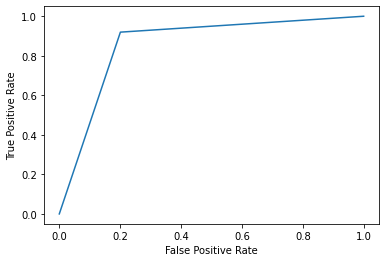

In [63]:
## ROC CURVE : Random Forest
# ========================================================================

def plot_roc_curve(predict, y_test):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(predict, y_test)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(predictions, y_test)
print(f'Random Forest AUC score : {100*roc_auc_score(predictions, y_test):.2f}% ')

In [65]:
print(f">Accuracy Score SVM: {100*acc_smv_2:.2f}%. \n>Accuracy Logistic Reggression: {100*acc_lr_2:.2f}%. \n>Accuracy Random Forest:{100*acc_rf_2:.2f}%.")

>Accuracy Score SVM: 88.28%. 
>Accuracy Logistic Reggression: 88.28%. 
>Accuracy Random Forest:84.93%.


> <b> Inference: </b> the model scores were lower than the previous ones. 

<h4> Oversampling</h4>

<p>Random oversampling duplicates examples from the minority class in the training dataset.</p>

In [66]:
oversample = RandomOverSampler(sampling_strategy='minority')
data, targ_over = oversample.fit_resample(corpus, targets)

In [67]:
Counter(targ_over)

Counter({0: 29677, 1: 29677})

C:\Users\carlo\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Non-racist'), Text(1, 0, 'Racist')]

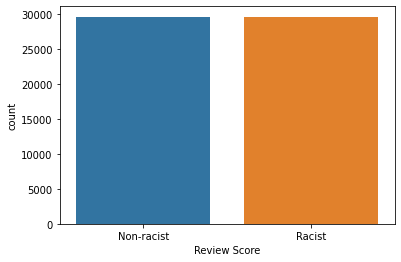

In [68]:
## Count targets
# ==========================================================

class_names = ['Non-racist', 'Racist']
ax = sns.countplot(targ_over)
plt.xlabel('Review Score')
ax.set_xticklabels(class_names)

In [69]:
## Split training and test data
# =================================================================

X_train, X_test, y_train, y_test = train_test_split(
                                   data, 
                                   targ_over, 
                                   random_state = 0) 

<h4> 6.7  SVM Model </h4>

In [70]:
# SVM Model
# ============================================================

clf = SVC(C = 100, kernel = 'linear', random_state=123)
clf.fit(X_train, y_train)

# Test predicctions
# ============================================================

predictions = clf.predict(X_test)

# Accuracy score
# ============================================================

acc_svm_3 = accuracy_score(
            y_true    = y_test,
            y_pred    = predictions
            )

print(f"Accuracy score for test data: {100*acc_svm_3 :.2f}%")

Accuracy score for test data: 98.72%


Model 1 AUC score : 98.76% 


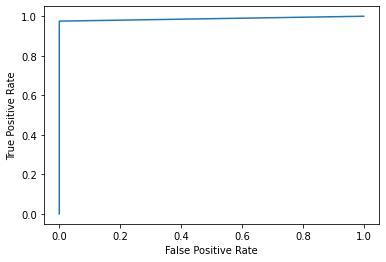

In [71]:
## ROC CURVE : SVM
# ========================================================================

def plot_roc_curve(predict, y_test):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(predict, y_test)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(predictions, y_test)
print(f'SVM Model AUC score : {100*roc_auc_score(predictions, y_test):.2f}% ')

<h4> 6.8 Logistic Regression Model </h4>

In [72]:
# Logistic Regression model 
# ============================================================

Logi_Reg = LogisticRegression()
Logi_Reg.fit(X_train, y_train)

# Test predicctions
# ============================================================

Predictions = Logi_Reg.predict(X_test)

# Accuracy score
# ============================================================

acc_lr_3 = accuracy_score(Predictions, y_test)

print(f'Accuracy score for the test data : {100*acc_lr_3 :.2f}%')

Accuracy score for the test data : 97.84%


Logistic Regression Model AUC score : 97.89% 


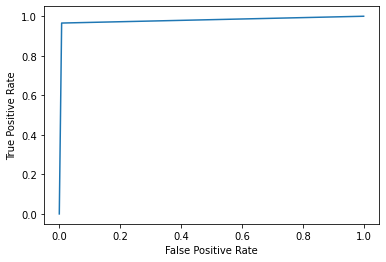

In [73]:
## ROC CURVE : Logistic Regression
# =============================================================

def plot_roc_curve(predict, y_test):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(predict, y_test)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(Predictions, y_test)
print(f'Logistic Regression Model AUC score : {100*roc_auc_score(Predictions, y_test):.2f}% ')

<h4> 6.9 Random Forest Model</h4>

In [75]:
# Random Forest model 
# ============================================================

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train) 

# Test predicctions
# ============================================================

predictions = clf.predict(X_test)

# Accuracy score
# ============================================================

acc_rf_3 = accuracy_score(predictions, y_test)
print(f'Accuracy score for the test data : {100*acc_rf_3 :.2f}%')

Accuracy score for the test data : 99.30%


Random Forest Model AUC score : 99.32% 


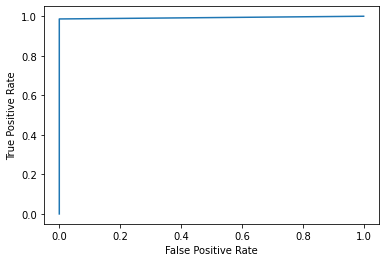

In [76]:
## ROC CURVE : Random Forest
# ========================================================================

def plot_roc_curve(predict, y_test):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(predict, y_test)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(predictions, y_test)
print(f'Random Forest Model AUC score : {100*roc_auc_score(predictions, y_test):.2f}% ')

In [77]:
print(f">Accuracy Score SVM: {100*acc_svm_3:.2f}%. \n>Accuracy Score Logistic Reggression: {100*acc_lr_3:.2f}%. \n>Accuracy Score Random Forest:{100*acc_rf_3:.2f}%.")

>Accuracy Score SVM: 98.72%. 
>Accuracy Score Logistic Reggression: 97.84%. 
>Accuracy Score Random Forest:99.30%.


> <b>Inference</b>: The Logistic Regression model obtained the best score.

<center> <h3> 7. Conclusions </h3> </center>

> <ul> 
    <li> The data set is unbalanced..</li>
    <li> The most frequently  words are: day, love, amp, happy, day.</li>
    <li> The most frequently  racist words are: </li>
    <li> The most frequently  non-racist words are: </li>
    <li> Random undersampling reduces the performance of machine learning models. </li>
    <li> Random oversampling increases model performance.  </li>
    <li> The Logistic Regression Model was the one that obtained better results than the rest.  </li>
  </ul> 

<center> <h3> Bonus: Implementation of a pre-trained model</h3></center>

In [103]:
data = pd.read_csv('df_clean.csv')

In [104]:
token_val = [str(i) for i in data['tweet'].values]
df = pd.DataFrame(token_val)
data = df.rename(columns = {0:'tweet'})
data

,tweet
0,father dysfunctional selfish drag kid dysfunct...
1,thanks lyft credit use offer wheelchair van pd...
2,bihday majesty
3,model love take time
4,factsguide society motivation
...,...
31957,ate isz youuu
31958,see nina turner airwave trying wrap mantle gen...
31959,listening sad song monday morning otw work sad
31960,sikh temple vandalised calgary wso condemns act


In [105]:
from transformers import pipeline 

In [106]:
SentimentClassifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


C:\Users\carlo\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\carlo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [107]:
def FunctionBERTSentiment(inpText):
    return(SentimentClassifier(inpText)[0]['label'])

In [108]:
FunctionBERTSentiment(inpText="I love you")

'POSITIVE'

In [116]:
data['tweet'][2]

'bihday majesty'

In [117]:
FunctionBERTSentiment(inpText=data['tweet'][2])

'POSITIVE'

In [119]:
data['Sentiment'] = data['tweet'].apply(FunctionBERTSentiment)

In [120]:
data.to_csv('Sentiment_tweet_bert.csv')

In [121]:
BERT_tweets= pd.read_csv('Sentiment_tweet_bert.csv')
BERT_tweets.drop('Unnamed: 0', axis=1)

,tweet,Sentiment
0,father dysfunctional selfish drag kid dysfunct...,NEGATIVE
1,thanks lyft credit use offer wheelchair van pd...,NEGATIVE
2,bihday majesty,POSITIVE
3,model love take time,POSITIVE
4,factsguide society motivation,NEGATIVE
...,...,...
31957,ate isz youuu,NEGATIVE
31958,see nina turner airwave trying wrap mantle gen...,NEGATIVE
31959,listening sad song monday morning otw work sad,NEGATIVE
31960,sikh temple vandalised calgary wso condemns act,NEGATIVE


<AxesSubplot:ylabel='None'>

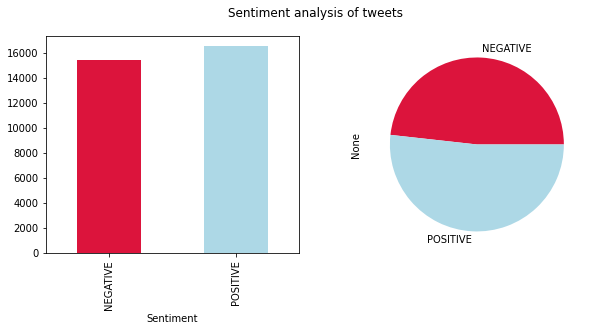

In [123]:
fig, subplot = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
fig.suptitle('Sentiment analysis of tweets')

group_data = data.groupby('Sentiment').size()


group_data.plot(kind ='bar', ax=subplot[0], color =['crimson', 'lightblue'])
group_data.plot(kind = 'pie', ax=subplot[1], colors =['crimson', 'lightblue'])